## Detección de Objetos

En posts anteriores hemos visto como podemos implementar y entrenar una `red neuronal convolucional` para encontrar objetos de interés en imágenes, definiendo una caja que engloba de manera precisa al objeto dentro de la imagen así como su categoría. De esta manera podemos saber dónde está el objeto y de qué objeto se trata. Sin embargo, en las implementaciones que hemos visto, sólo eramos capaces de localizar un objeto en cada imagen. En aplicaciones reales, vamos a querer poder ser capaces de localizar todos los objetos que aparecen en una imagen. A esta tarea se la conoce como `detección de objetos` y nuestra red neuronal será responsable de devolvernos una lista, de longitud arbitraria, de cajas y categorías identificando el máximo número de objetos posibles en la imagen. Este tipo de modelos son clave en aplicaciones como conducción autónoma, en la que queremos detectar otros vehículos, peatones, ciclistas, semáforos, señales... Todo en una sola imagen.

![](https://www.rysspty.com/wp-content/uploads/2020/02/Tesla-Autopliot.gif)

## Tipos de detectores

Existen dos grandes grupos de arquitecturas utilizadas para la detección de objetos:

- Detectores de dos etapas: En una primera etapa, la red neuronal propone las cajas en las que cree que se encuentran los objetos. En una segunda, el modelo clasifica los objetos dentro de las cajas propuestas. Estos modelos son más precisos pero computacionalmente más caros, lo que limita su aplicabilidad en aplicaciones en tiempo real.
- Detectores de una etapa: Estos modelos dan las cajas y clasificaciones a la vez, en una sola etapa. Para ello, utilizan un conjunto de cajas pre-definido. Estos modelos son menos precisos pero muy eficientes, por lo que se utilizan en aplicaciones en tiempo real.

### Detectores de dos etapas

Entre estos detectores destacan los conocidos como la familia `R-CNN`. Fueron los primeros detectores en incorporar redes neuronales convolucionales, mejorando considerablemente los resultados obtenidos hasta la fecha con otros algoritmos. El primer modelo de la familia, R-CNN, utilizaba una primera etapa en la que se proponen las cajas (originalmente no usaba una red neuronal) y luego una `CNN` como las que ya conocemos para clasificar los objetos en cada caja.

![](https://3qeqpr26caki16dnhd19sv6by6v-wpengine.netdna-ssl.com/wp-content/uploads/2019/03/Summary-of-the-R-CNN-Model-Architecture.png)

Mejoras a este algoritmos se propusieron en los años consecuentes, por ejemplo el modelo `Fast R-CNN` utiliza un conjunto de cajas predefinido siendo más eficiente.

![](https://3qeqpr26caki16dnhd19sv6by6v-wpengine.netdna-ssl.com/wp-content/uploads/2019/03/Summary-of-the-Fast-R-CNN-Model-Architecture.png)

y el modelo `Faster R-CNN` implementa nuevas mejoras, ahora las cajas son propuestas directamente por la red neuronal, convirtiéndolo en unos de los modelos más utilizados a día de hoy

![](https://3qeqpr26caki16dnhd19sv6by6v-wpengine.netdna-ssl.com/wp-content/uploads/2019/03/Summary-of-the-Faster-R-CNN-Model-Architecture.png)

El último miembro de la família es `Mask R-CNN`, que no solo permite la detección de objetos sino también la segmentación en un mismo modelo.

![](https://miro.medium.com/max/770/1*dYb3w2iVxkN7Ifx-eA8ZRg.jpeg)

### Detectores de una etapa

Entre los detectores de una etapa, destacan el modelo `YOLO` (*you only look once*) que divide la imagen de entrada en una malla pre-definida. Cada celda es entonces responsable de predecir las cajas y las categorías a la vez. Mejores a este modelo se implementaron en `YOLOv2` y `YOLOv3`, mejorando tanto su eficiencia como precisión.

![](https://3qeqpr26caki16dnhd19sv6by6v-wpengine.netdna-ssl.com/wp-content/uploads/2019/03/Summary-of-Predictions-made-by-YOLO-Model.png)

El modelo `SSD` es uno de los más utilizados, ya que representa un buen compromiso entre prestaciones y eficiencia (utilizado sobretodo en entornos con bajos recursos computacionales y aplicaciones en tiempo real como teléfonos móviles y IoT). Utiliza un conjunto de cajas pre-definidas, y durante el entrenamiento el modelo refina y clasifica cada una de estas cajas a diferentes escalas.

![](https://miro.medium.com/max/1100/1*up-gIJ9rPkHXUGRoqWuULQ.jpeg)

Más adelante se propuso el modelo de `Retinanet`, cuya principal aportación fue el uso de una nueva función de pérdida llamada `Focal Loss`. Esta función le permite al modelo prestar más atención a aquellos objetos de los que está menos seguro, mejorando las prestaciones de los detectores de una sola etapa.

![](https://miro.medium.com/max/1000/1*zERubQo3gW3Jot0iM6a9vw.png)

Sin embargo, el `state-of-the-art` a día de hoy lo encontramos en los modelos llamados `EfficientDet`, modelos similares a los anteriores pero que utilizan la arquitectura `EfficientNet` en el `backbone` (además de otros "trucos") dando lugar a un modelo eficiente y preciso.

![](https://miro.medium.com/max/770/1*fWcTncW1FRCfR_XgE_8jSg.png)

## Ejemplo  de uso

Vamos a ver como podemos utilizar el modelo `Faster R-CNN` disponible en `torchvision` para generar detecciones. En primer lugar vamos a utilizar el mismo dataset que hemos usado en los vídeos anteriores, el dataset `VOC` (el modelo `Faster R-CNN` de `torchvision` está entrenado en el dataset `COCO`)

In [1]:
import torch
import torchvision
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [2]:
train = torchvision.datasets.VOCDetection('./data', download=True)
len(train)

100%|██████████| 1999639040/1999639040 [01:02<00:00, 31881892.12it/s]


Extracting ./data/VOCtrainval_11-May-2012.tar to ./data


5717

In [3]:
voc_classes = ["background",
            "aeroplane",
            "bicycle",
            "bird",
            "boat",
            "bottle",
            "bus",
            "car",
            "cat",
            "chair",
            "cow",
            "diningtable",
            "dog",
            "horse",
            "motorbike",
            "person",
            "pottedplant",
            "sheep",
            "sofa",
            "train",
            "tvmonitor"]

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.patheffects as PathEffects
import random

def get_sample(ix):
  img, label = train[ix]
  img_np = np.array(img)
  anns = label['annotation']['object']
  if type(anns) is not list:
    anns = [anns]
  labels = np.array([voc_classes.index(ann['name']) for ann in anns])
  bbs = [ann['bndbox'] for ann in anns]
  bbs = np.array([[int(bb['xmin']), int(bb['ymin']),int(bb['xmax'])-int(bb['xmin']),int(bb['ymax'])-int(bb['ymin'])] for bb in bbs])
  anns = (labels, bbs)
  return img_np, anns

def plot_anns(img, anns, ax=None, bg=-1, classes=voc_classes):
  # anns is a tuple with (labels, bbs)
  # bbs is an array of bounding boxes in format [x_min, y_min, width, height] 
  # labels is an array containing the label 
  if not ax:
    fig, ax = plt.subplots(figsize=(10, 6))
  ax.imshow(img)
  labels, bbs = anns
  for lab, bb in zip(labels, bbs):
    if bg == -1 or lab != bg:
      x, y, w, h = bb
      rect = mpatches.Rectangle((x, y), w, h, fill=False, edgecolor='red', linewidth=2)
      text = ax.text(x, y - 10, classes[lab], {'color': 'red'})
      text.set_path_effects([PathEffects.withStroke(linewidth=5, foreground='w')])
      ax.add_patch(rect)

In [5]:
r, c = 3, 4
fig = plt.figure(figsize=(4*c, 4*r))
for _r in range(r):
    for _c in range(c):
        ax = plt.subplot(r, c, _r*c + _c + 1)
        ix = random.randint(0, len(train)-1)
        img_np, anns = get_sample(ix)
        plot_anns(img_np, anns, ax)
        plt.axis("off")
plt.tight_layout()
plt.show()

Output hidden; open in https://colab.research.google.com to view.

Ahora podemos descargar el modelo entrenado

In [6]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
model

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:02<00:00, 75.2MB/s]


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

Siguiendo la documentación, podemos usar este modelo en inferencia pasándole una lista de imágenes normalizadas entre 0-1 con las dimensiones `[C, H, W]` (pueden ser imágenes de diferente tamaño, el modelo ya se encarga del *resize*).

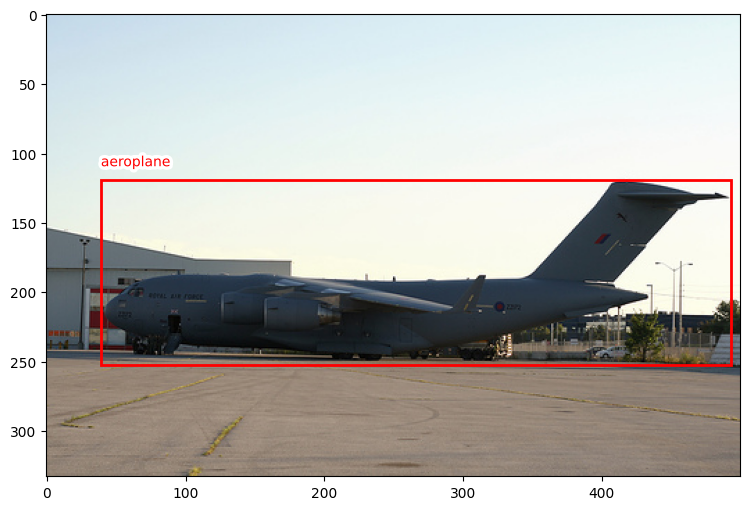

In [7]:
img_np, anns = get_sample(4445)
plot_anns(img_np, anns)
plt.show()

In [8]:
model.eval()
outputs = model([torch.tensor(img_np / 255.).permute(2,0,1).float()])
outputs

[{'boxes': tensor([[ 37.4376, 123.0881, 465.7533, 244.7145],
          [395.2054, 239.3289, 417.7919, 248.7811],
          [ 83.6134, 212.1356,  97.7281, 245.2005],
          [389.6237, 239.5253, 405.0975, 248.0252],
          [ 40.6147, 171.6959, 375.7797, 246.6191],
          [394.6273, 241.2377, 407.7459, 248.6640],
          [297.5121, 236.5061, 326.4868, 249.9926],
          [297.9731, 236.9063, 325.1756, 250.0177],
          [230.6489, 119.3883, 486.6216, 229.6476],
          [ 87.7585, 211.9286,  96.6415, 232.8783],
          [273.1853, 239.2790, 299.6663, 248.0576],
          [390.4716, 239.0620, 402.1634, 245.3496],
          [ 76.5685, 229.0903,  82.8707, 246.0610],
          [  1.2251, 227.7767,  25.1209, 241.2924],
          [268.6220, 238.7137, 300.8833, 249.2730],
          [400.6866, 238.5920, 417.8362, 245.3861],
          [ 81.3748, 220.6622,  88.8553, 244.8086],
          [  1.2523, 231.9601,  17.4334, 241.2444]], grad_fn=<StackBackward0>),
  'labels': tensor([ 5,  3,

A la salida recibimos una lista con las detecciones de cada imagen (en nuestro caso solo una). Cada elemento de la lista es un `dict` con las cajas, etiquetas y las probabilidades asignadas a cada objeto detectado (que podemos filtrar para quedarnos, por ejemplo, con aquellas detecciones con probabilidad superior a un cierto valor). Es importante recordar que estas etiquetas corresponden al dataset `COCO`.

In [9]:
COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

Además, las cajas están en formato `[x_min, y_min, x_max, y_max]` mientras que nosotros estamos trabajando con `[x_min, y_min, width, height]`, por lo que tenemos que transformar las cajas.

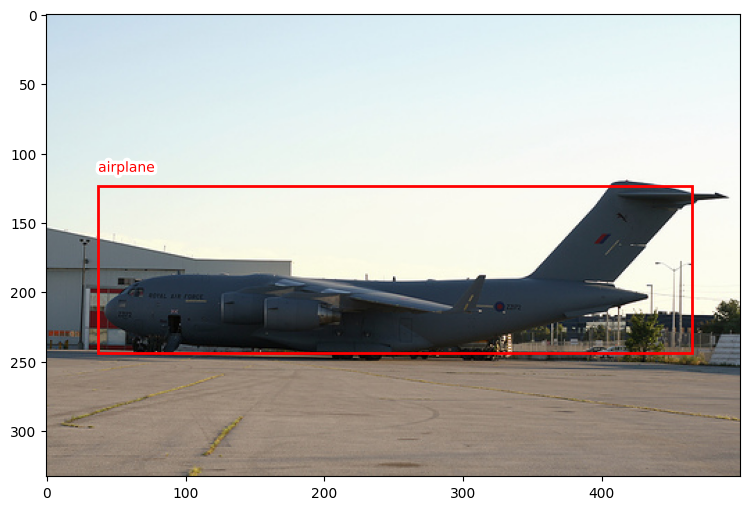

In [10]:
img_np, anns = get_sample(4445)
# nos quedamos con la primera detección
bb = outputs[0]['boxes'][0].long().tolist()
bb = [bb[0], bb[1], bb[2]-bb[0], bb[3]-bb[1]]
plot_anns(img_np, (outputs[0]['labels'][:1], [bb]), classes=COCO_INSTANCE_CATEGORY_NAMES)
plt.show()

Puedes jugar con las siguientes celdas para ver detecciones sobre imágenes aleatorias del dataset. Debido a que el dataset `COCO` tiene mucha clases que el dataset `VOC` (90 vs 20), muchos objetos detectados correctamente pueden no aparecer en las anotaciones originales.

In [11]:
def predict(img, threshold=0.8):
    model.eval()
    outputs = model([torch.tensor(img_np / 255.).permute(2,0,1).float()])
    # nos quedamos con la primera detección
    bb = outputs[0]['boxes'][0].long().tolist()
    bbs = [[bb[0], bb[1], bb[2]-bb[0], bb[3]-bb[1]] for o in outputs for bb, score in zip(o['boxes'], o['scores']) if score > threshold]
    labels = [lab for o in outputs for lab, score in zip(o['labels'], o['scores']) if score > threshold]
    return labels, bbs

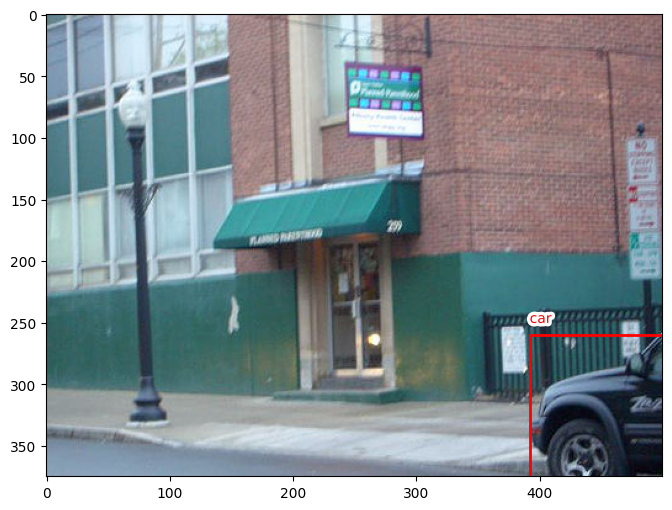

In [12]:
ix = random.randint(0, len(train)-1)
img_np, anns = get_sample(ix)
plot_anns(img_np, anns)
plt.show()

Si bien puedes utilizar este modelo ya entrenado para generar predicciones, si tu tarea incluye otros objetos no presentes en el dataset original tendrás que hacer `fine-tuning`, reentrenando la red con tu dataset. Puedes encontrar en la [documentación](https://pytorch.org/docs/stable/torchvision/models.html) instrucciones para entrenar de nuevo el modelo.

## Resumen

En este post hemos introducido la tarea de `detección de objetos` con `redes neuronales`. Esta tarea consiste en localizar y clasificar el máximo número de objetos presentes en una imagen. Hemos visto que existen dos grandes familias de arquitecturas: modelos de dos etapas (más lentos pero más precisos) y modelos de una etapa (más rápidos pero menos precisos). En función de nuestra aplicación (principalmente si es en tiempo real o no), elegiremos unos modelos u otros. También hemos visto como podemos usar el modelo `Fast R-CNN` entrenado para generar predicciones, aunque si nuestra tarea incluye otras clases no presentes en el dataset `COCO` tendremos que re-entrenar la red con nuestros datos. 